In [2]:
# %% Import
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

In [3]:
# %% Define functions

def autocorr(x,k):
  '''returns the lag-k autocorrelation of vector x'''
  x = x.reshape(-1,1)
  return sm.tsa.acf(x)[1]

def thomasfiering(x, T, N):
  '''Lag-1 model. use historical data x 
  to generate N synthetic sequences of T timesteps.
  Assumes x is lognormally distributed.'''

  # Set random seed; not interactive mode, a script, dont need this as var
  np.random.seed(5)

  # Log transform of data
  x = np.log(x) # log-space avoids negative values

  # Calculate mean, variance, lag-1 autocorrelation
  mu = x.mean()
  sigma = x.std()
  rho = autocorr(x,1)
  # Note the retransformation bias in rho

  # Initialize the a N x T matrix where you will save streamflow values
  Q = np.zeros([N, T])
  Q[:, 0] = np.random.normal(mu,sigma,1)  # Choose starting value

  # Loop over time, and simulate AR(1) for each
  # Note instead of looping over N, we vectorize
  for i in range(1, T):
    Z = np.random.standard_normal(N)
    Q[:, i] = mu + rho*(Q[:, i-1] - mu) + Z*sigma*np.sqrt(1-rho**2)

  return np.exp(Q)

Means: 2668.313890, 2747.397946
Stdev: 1345.698520, 1632.998917
Rho: 0.152363, 0.128409


/Users/natram3/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/Users/natram3/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


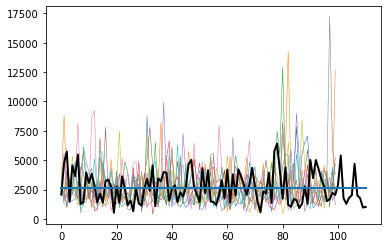

In [4]:
 # %% Apply to Folsom data

# assume annual flow data is lognormally distributed
# Load data
Q = np.loadtxt('folsom-annual-1.csv', delimiter=',', skiprows=1, usecols=[1])

Q_synthetic = thomasfiering(Q, T=100, N=10)

print('Means: %f, %f' % (Q.mean(),Q_synthetic.mean()))
print('Stdev: %f, %f' % (Q.std(),Q_synthetic.std()))
print('Rho: %f, %f' % (autocorr(Q,1), autocorr(Q_synthetic,1)))

plt.set_cmap('gray')
plt.plot(np.transpose(Q_synthetic), linewidth=.5)
plt.plot(Q, color='black', linewidth=2)
plt.plot([0,110], [Q.mean(), Q.mean()], linewidth=2)
plt.show()


In [9]:
# %% Calculate frequency of multi-year droughts
# Define drought threshold as 80% of mean and length of at least 4 years
threshold = Q.mean() * .8
droughtLen = 4

def multi_year_drought_freq(Q, threshold, droughtLen):
  '''Count the average number of droughts that are at least as long as droughLen
    in each streamflow timeseries Q.
    Q can either be a N x T matrix or a vector with a single time series of length T'''

  # Get N and T from Q - the try except is used to handle either matrix or vector input
  try:
    T = np.shape(Q)[1]
    N = len(Q)
  except:
    N = 1
    T = len(Q)

  # If N = 1, turn vector into 2D matrix so indexing workds
  if N == 1:
    Q = Q.reshape(1, -1)

  # Initialize vector to save number of multi year droughts in each time series
  numNYrDrought = np.zeros(N)

  # Loop over each time series (could vectorize this to improve speed)
  for i in range(N):

    # Get vector for a single time series
    Q_now = Q[i,:]

    # Find which values are below the drought threshold - True means drought
    below = Q_now < threshold

    # Count the length of each consecutive set of true values (just trust me it works)
    consecTrue = np.diff(np.where(np.concatenate(([below[0]], below[:-1] != below[1:], [True])))[0])[::2]

    # Count the number of consecutive drought occurences with at least minimum length
    numNYrDrought[i] = np.sum(consecTrue >= droughtLen)

  # Average number of three year droughts over all the time series
  avgNYrDrought = np.mean(numNYrDrought)

  return avgNYrDrought, T


avgNYrDrought, T = multi_year_drought_freq(Q_synthetic, threshold, droughtLen)
print('On average, a {}-year drought occurs {} times in a {} year period'.format(droughtLen, avgNYrDrought, T))

avgNYrDrought, T = multi_year_drought_freq(Q.T, threshold, droughtLen)
print('A {}-year drought occured {} times in the {}-year historical record'.format(droughtLen, avgNYrDrought, T))


On average, a 4-year drought occurs 2.2 times in a 100 year period
A 4-year drought occured 4.0 times in the 111-year historical record


In [ ]:
# Note you can import another file and use the functions from that file
from thomas_fiering_annual import thomasfiering
from thomas_fiering_annual import autocorr

# %% Calcualte annual daily from daily data

# load data of daily flows on the Potomac at DC [cfs]
dailyQ= pd.read_csv('../Data/Potomac_DC.csv')

# convert first column to date
dailyQ['Date'] = pd.to_datetime(dailyQ['Date'],format="%Y-%m-%d")
dailyQ['Flow'] = pd.to_numeric(dailyQ['Flow'],errors='ignore')

# find year of each data point
dailyQ['Year'] = dailyQ['Date'].dt.year
years = np.unique(dailyQ['Year'])

# Delete leap days
dailyQ = dailyQ[~((dailyQ.Date.dt.month == 2) & (dailyQ.Date.dt.day == 29))]

# Delete first and last year if data incomplete
dailyQ = dailyQ[~(dailyQ['Year'] == 2019)]
dailyQ = dailyQ[~(dailyQ['Year'] == 1930)]

# Fill in a nan value
dailyQ = dailyQ.fillna(method='ffill')

# Get annual flow
annQ = np.array(dailyQ.groupby('Year').mean()['Flow'])

# %% Use Thomas Fiering to simulate an annual flow time series based on historical

annQsyn = thomasfiering(annQ, T=200, N=1)
annQsyn = annQsyn[0]

# %% Now start daily disaggretation using K-nn

#  Calculate daily proportion matrix P from historical data

# Reshape daily data into matrix
dailyQMatrix = np.array(dailyQ['Flow']).reshape(-1, 365)

# Calculate annual sum i.e. sum of each row
annSum = np.sum(dailyQMatrix, 1)

# Normalize daily values by annual value
P = dailyQMatrix / annSum[:, None]

# Check that daily values sum to one
tol = .0001
assert np.sum(np.abs(np.sum(P, 1) - 1) > tol) == 0, 'rows should sum to 1'

plt.figure()
plt.plot(P.T)
plt.title('P')
plt.show()


# %% Resample using k nearest neighbors

# Get number of years in synthetic series
N = len(annQ)
# Choose K as sqrt of N following Lall and Sharma 1996
k = np.int(np.sqrt(N))

# Initialize
dailyQResampled = np.zeros([N, 365])

for i in range(N):

    # For the current synthetic value, find the indicies of the
    # k nearest neighbors in the historical record
    kNN_ind = np.argsort(np.abs(annQsyn[i] - annQ))[0:k]

    # Calculate the weights and check they sum to 1
    W = [(1/i) / np.sum(1 / np.arange(1,k+1)) for i in np.arange(1,k+1)]
    assert np.sum(W) == 1.0, 'weights should sum to 1'

    # Sample a year from historical reocrd with weights W
    cumW = np.cumsum(W)
    rnd = np.random.rand()
    samp_ind = kNN_ind[np.where(rnd < cumW)[0][0]]

    # Get daily proportion series from sampled year and use to disaggregate
    # annual synthetic flow to daily flow
    dailyQResampled[i,:] = annQsyn[i] * P[samp_ind, :] * 365



# %% Plot synthetic daily flows

meanDailyQ = np.mean(np.array(dailyQ['Flow']).reshape(365,-1),1)
plt.figure()
plt.plot( dailyQResampled.T)
plt.title('Synthetic daily flows')

plt.show()

plt.figure()
plt.plot( dailyQMatrix.T )
plt.title('Historical daily flows')
plt.show()

